# Load the dataset

In [5]:
import pandas as pd
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, SVI, Trace_ELBO, autoguide
import jax.numpy as jnp
from jax import random
import arviz as az
import optax  # Optimizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal
from iminuit import Minuit

In [3]:
# Load the dataset
file_path = "dataverse_files/1-Fragment_C_Hole_Measurements.csv"
df = pd.read_csv(file_path)

# Extract coordinates and section info
measured_x = df['Mean(X)'].values
measured_y = df['Mean(Y)'].values
sections = df['Section ID'].values

# Write the NumPyro Model

## Hole Index to Section Mapping
Note that we have ignored hole_index = 0 in Section 0 and hole_index = 69 in Section 4

| Hole Index | sec_id | Original Section |
|------------|--------|------------------|
| 1 - 22     | 0      | 1                |
| 23 - 31    | 1      | 2                |
| 32 - 68    | 2      | 3                |
| 70 - 72    | 3      | 5                |
| 73 - 74    | 4      | 6                |
| 75 - 80    | 5      | 7                |

In [2]:
def model(x, y, num_sections=6):

    # Define priors
    N_original = numpyro.sample('N', dist.Uniform(340, 370))  # Continuous parameter
    r = numpyro.sample('r', dist.Uniform(70, 85))
    sigma_r = numpyro.sample('sigma_r', dist.HalfNormal(0.04))
    sigma_t = numpyro.sample('sigma_t', dist.HalfNormal(0.15))

    x0 = numpyro.sample('x0', dist.Normal(80, 3), sample_shape=(num_sections,))
    y0 = numpyro.sample('y0', dist.Normal(135, 2), sample_shape=(num_sections,))
    alpha = numpyro.sample('alpha', dist.Normal(-145, 2), sample_shape=(num_sections,))
    alpha_rad = jnp.deg2rad(alpha)

    # Define likelihood function
    for i in range(len(x)):
        # skip single holes
        if i == 0 or i == 69:
            continue
        
        original_sec_id = sections[i]
        if original_sec_id == 1:
            sec_id = 0
        elif original_sec_id == 2:
            sec_id = 1
        elif original_sec_id == 3:
            sec_id = 2
        elif original_sec_id == 5:
            sec_id = 3
        elif original_sec_id == 6:
            sec_id = 4
        elif original_sec_id == 7:
            sec_id = 5

        # angle of hole i in radian
        phi = 2 * jnp.pi * i / N_original + alpha_rad[sec_id] # note the slight difference from paper, because hole index starts from 0 in the code

        # Predicted position
        mx = r * jnp.cos(phi) + x0[sec_id]
        my = r * jnp.sin(phi) + y0[sec_id]
        
        # Transform error into local radial/tangential coordinates
        dx = x[i] - mx
        dy = y[i] - my
        
        # Rotate into radial/tangential frame
        dr = dx * jnp.cos(phi) + dy * jnp.sin(phi)   # Radial error
        dt = dx * jnp.sin(phi) - dy * jnp.cos(phi)   # Tangential error
        
        # Independent Gaussian noise in the radial/tangential frame and multiplied together
        numpyro.sample(
            f'obs_{i}',
            dist.MultivariateNormal(
                loc=jnp.array([0.0, 0.0]),
                covariance_matrix=jnp.diag(jnp.array([sigma_r**2, sigma_t**2]))
            ),
            obs=jnp.array([dr, dt])
        )

# Run the MCMC

In [5]:
rng_key = random.PRNGKey(3)
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=5000, num_samples=10000, num_chains=2)
mcmc.run(rng_key, x=measured_x, y=measured_y, num_sections=6)
samples = mcmc.get_samples()

/var/folders/zx/j5d_p2_s2wz05zg3b78717100000gn/T/ipykernel_28718/339531168.py:3: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=5000, num_samples=10000, num_chains=2)
sample: 100%|██████████| 15000/15000 [1:11:52<00:00,  3.48it/s, 255 steps of size 1.02e-02. acc. prob=0.94] 


# Extract results

In [6]:
posterior = az.from_numpyro(mcmc)
summary = az.summary(posterior)
print(summary)

             mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
N         355.419  1.287  353.011  357.831      0.021    0.012    3724.0   
alpha[0] -145.721  0.062 -145.828 -145.595      0.001    0.000    6512.0   
alpha[1] -145.658  0.185 -145.998 -145.311      0.002    0.001    8984.0   
alpha[2] -145.514  0.185 -145.844 -145.155      0.003    0.002    3807.0   
alpha[3] -146.270  0.772 -147.735 -144.833      0.007    0.006   11285.0   
alpha[4] -145.465  1.156 -147.707 -143.346      0.011    0.009   11226.0   
alpha[5] -147.655  0.406 -148.400 -146.872      0.005    0.003    6706.0   
r          77.362  0.261   76.858   77.839      0.004    0.003    3459.0   
sigma_r     0.028  0.003    0.024    0.033      0.000    0.000   17797.0   
sigma_t     0.130  0.011    0.110    0.151      0.000    0.000   19521.0   
x0[0]      79.707  0.187   79.367   80.068      0.003    0.002    3654.0   
x0[1]      79.918  0.222   79.505   80.340      0.003    0.002    7820.0   
x0[2]      7

/Users/zhimeiliu/Downloads/DIS/dis_sheet/lib/python3.12/site-packages/arviz/plots/backends/matplotlib/pairplot.py:233: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


array([[<Axes: ylabel='N'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='alpha\n0'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='alpha\n1'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='alpha\n2'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='alpha\n3'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='alpha\n4'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='alpha\n5'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='N', ylabel='r'>, <Axes: xlabel='alpha\n0'>,
        <Axes: xlabel='alpha\n1'>, <Axes: xlabel='alpha\n2'>,
        <Axes: xlabel='alpha\n3'>, <Axes: xlabel='alpha\n4'>,
        <Axes: xla

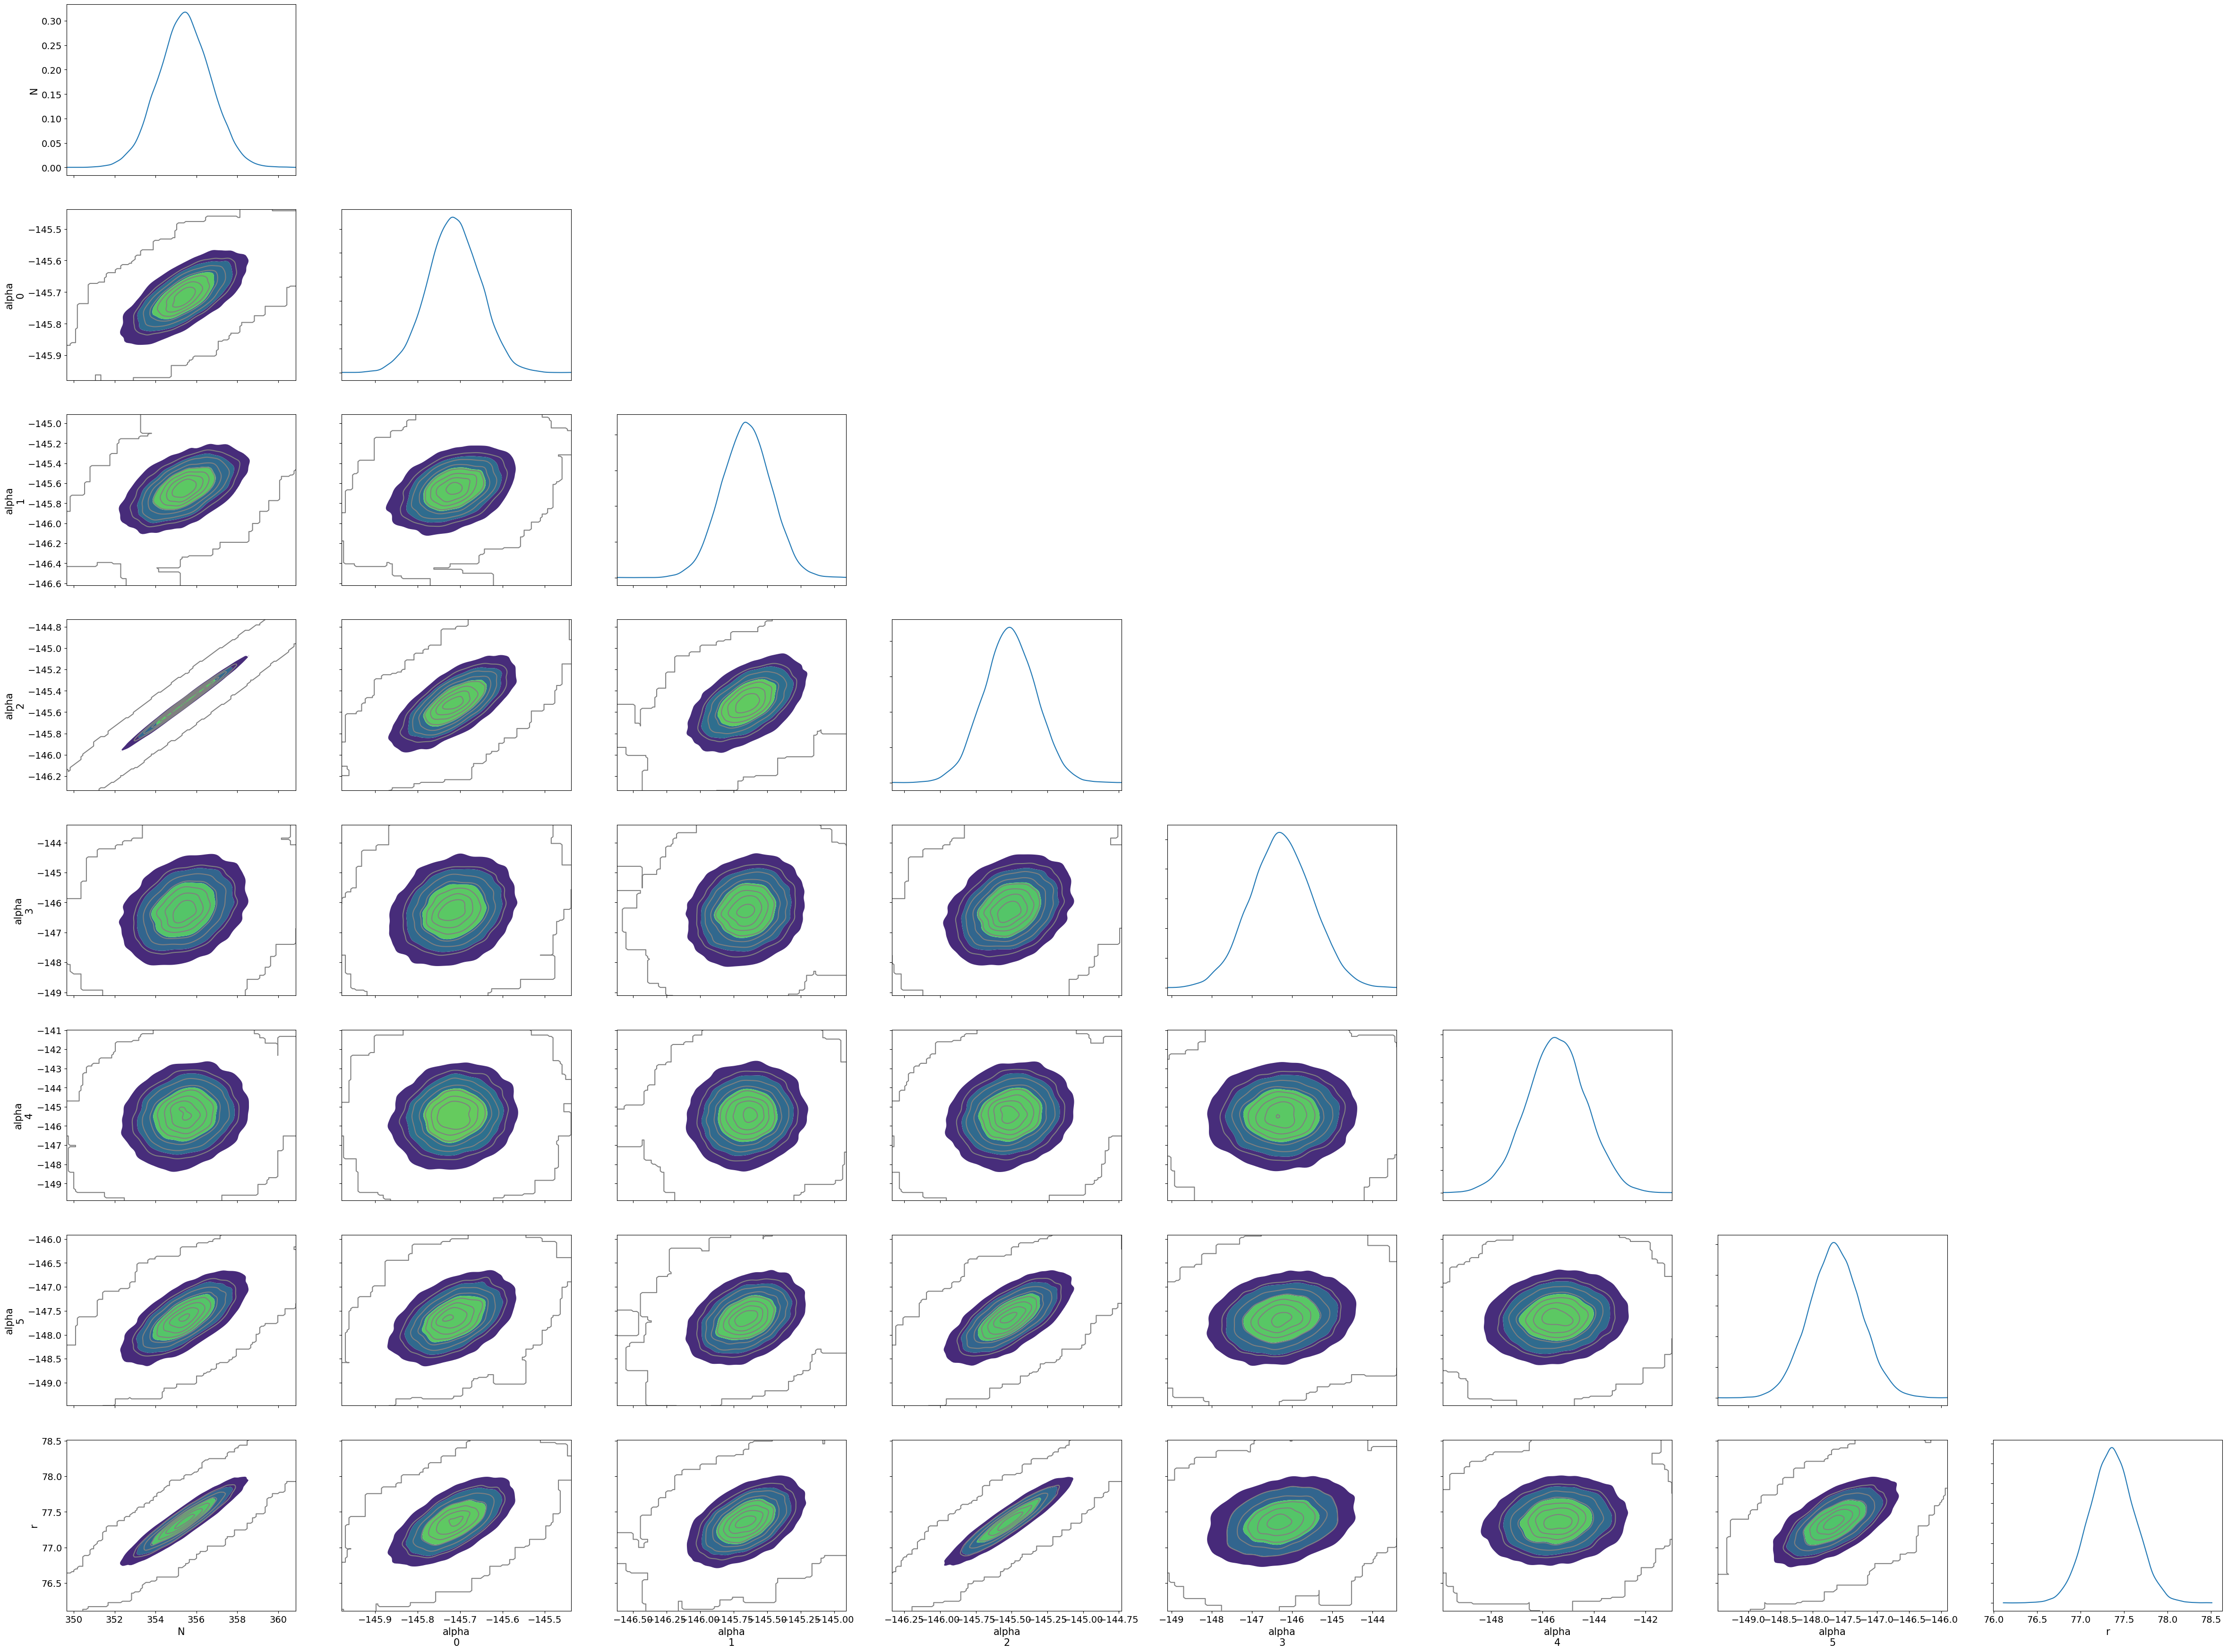

In [30]:
az.plot_pair(posterior, kind='kde', marginals=True)

# (e) Find MLE with Minuit

In [4]:
def make_neg_log_likelihood(x_data, y_data, sections_data):
    def neg_log_likelihood(
        N_original, r, sigma_r, sigma_t,
        x0_0, x0_1, x0_2, x0_3, x0_4, x0_5,
        y0_0, y0_1, y0_2, y0_3, y0_4, y0_5,
        alpha_0, alpha_1, alpha_2, alpha_3, alpha_4, alpha_5
    ):
        log_likelihood = 0.0
        
        # Combine the separate parameters back into arrays
        x0 = np.array([x0_0, x0_1, x0_2, x0_3, x0_4, x0_5])
        y0 = np.array([y0_0, y0_1, y0_2, y0_3, y0_4, y0_5])
        alpha = np.array([alpha_0, alpha_1, alpha_2, alpha_3, alpha_4, alpha_5])
        alpha_rad = np.deg2rad(alpha)

        for i in range(len(x_data)):
            if i == 0 or i == 69:
                continue
            
            original_sec_id = sections_data[i]
            if original_sec_id == 1:
                sec_id = 0
            elif original_sec_id == 2:
                sec_id = 1
            elif original_sec_id == 3:
                sec_id = 2
            elif original_sec_id == 5:
                sec_id = 3
            elif original_sec_id == 6:
                sec_id = 4
            elif original_sec_id == 7:
                sec_id = 5

            phi = 2 * np.pi * i / N_original + alpha_rad[sec_id]
            
            mx = r * np.cos(phi) + x0[sec_id]
            my = r * np.sin(phi) + y0[sec_id]
            
            dx = x_data[i] - mx
            dy = y_data[i] - my
            
            # Rotate into radial/tangential frame
            dr = dx * np.cos(phi) + dy * np.sin(phi)
            dt = dx * np.sin(phi) - dy * np.cos(phi)
            
            # Multivariate normal likelihood
            cov_matrix = np.diag([sigma_r**2, sigma_t**2])
            log_likelihood += multivariate_normal.logpdf([dr, dt], mean=[0, 0], cov=cov_matrix)

        return -log_likelihood
    
    return neg_log_likelihood

# Create the likelihood function with the data
neg_ll = make_neg_log_likelihood(measured_x, measured_y, sections)

# Initial guesses for the parameters
initial_params = {
    "N_original": 350,       # Midpoint of Uniform(340, 370)
    "r": 77.5,               # Midpoint of Uniform(70, 85)
    "sigma_r": 0.04,         # HalfNormal(0.04) mode
    "sigma_t": 0.15,         # HalfNormal(0.15) mode
    "x0": np.random.normal(80, 3, 6),
    "y0": np.random.normal(135, 2, 6),
    "alpha": np.random.normal(-145, 2, 6),
}

# Create the Minuit object
m = Minuit(
    neg_ll,
    N_original=initial_params["N_original"],
    r=initial_params["r"],
    sigma_r=initial_params["sigma_r"],
    sigma_t=initial_params["sigma_t"],
    x0_0=initial_params["x0"][0],
    x0_1=initial_params["x0"][1],
    x0_2=initial_params["x0"][2],
    x0_3=initial_params["x0"][3],
    x0_4=initial_params["x0"][4],
    x0_5=initial_params["x0"][5],
    y0_0=initial_params["y0"][0],
    y0_1=initial_params["y0"][1],
    y0_2=initial_params["y0"][2],
    y0_3=initial_params["y0"][3],
    y0_4=initial_params["y0"][4],
    y0_5=initial_params["y0"][5],
    alpha_0=initial_params["alpha"][0],
    alpha_1=initial_params["alpha"][1],
    alpha_2=initial_params["alpha"][2],
    alpha_3=initial_params["alpha"][3],
    alpha_4=initial_params["alpha"][4],
    alpha_5=initial_params["alpha"][5],
)

# Set parameter limits (matching your priors)
m.limits["N_original"] = (340, 370)
m.limits["r"] = (70, 85)
m.limits["sigma_r"] = (0, None)  # HalfNormal
m.limits["sigma_t"] = (0, None)  # HalfNormal

# Set reasonable step sizes
m.errors["N_original"] = 1
m.errors["r"] = 0.1
m.errors["sigma_r"] = 0.01
m.errors["sigma_t"] = 0.01

for i in range(6):
    m.errors[f"x0_{i}"] = 0.1
    m.errors[f"y0_{i}"] = 0.1
    m.errors[f"alpha_{i}"] = 0.1

# Perform the minimization
m.migrad()

# Print the results with 3 decimal places
print(f"Optimized N_original: {m.values['N_original']:.3f}")
print(f"Optimized r: {m.values['r']:.3f}")
print(f"Optimized sigma_r: {m.values['sigma_r']:.3f}")
print(f"Optimized sigma_t: {m.values['sigma_t']:.3f}")
print("Optimized x0:", [f"{m.values[f'x0_{i}']:.3f}" for i in range(6)])
print("Optimized y0:", [f"{m.values[f'y0_{i}']:.3f}" for i in range(6)])
print("Optimized alpha:", [f"{m.values[f'alpha_{i}']:.3f}" for i in range(6)])

Optimized N_original: 355.237
Optimized r: 77.336
Optimized sigma_r: 0.026
Optimized sigma_t: 0.123
Optimized x0: ['79.689', '79.907', '79.860', '81.436', '81.519', '83.220']
Optimized y0: ['136.031', '135.715', '135.706', '136.101', '135.843', '136.420']
Optimized alpha: ['-145.721', '-145.673', '-145.539', '-146.704', '-146.327', '-147.805']


## Plot predicted hole locations from MLE

In [6]:
# Extract MLE parameter values
N_mle = m.values['N_original']  
r_mle = m.values['r']
x0_mle = [m.values[f'x0_{i}'] for i in range(6)]
y0_mle = [m.values[f'y0_{i}'] for i in range(6)]  
alpha_mle = np.deg2rad([m.values[f'alpha_{i}'] for i in range(6)])

# Compute predicted hole locations
predicted_x, predicted_y = [], []
for i, (_, row) in enumerate(df.iterrows()):
    original_sec = int(row["Section ID"])
    
    if original_sec == 0 or original_sec == 4:
        mx = row["Mean(X)"]
        my = row["Mean(Y)"]
    else:
        if original_sec == 1:
            sec_id = 0
        elif original_sec == 2:
            sec_id = 1
        elif original_sec == 3:
            sec_id = 2
        elif original_sec == 5:
            sec_id = 3
        elif original_sec == 6:
            sec_id = 4
        elif original_sec == 7:
            sec_id = 5
        
        phi = (2 * np.pi * i / N_mle) + alpha_mle[sec_id]

        mx = r_mle * np.cos(phi) + x0_mle[sec_id]
        my = r_mle * np.sin(phi) + y0_mle[sec_id]

    predicted_x.append(mx)
    predicted_y.append(my)

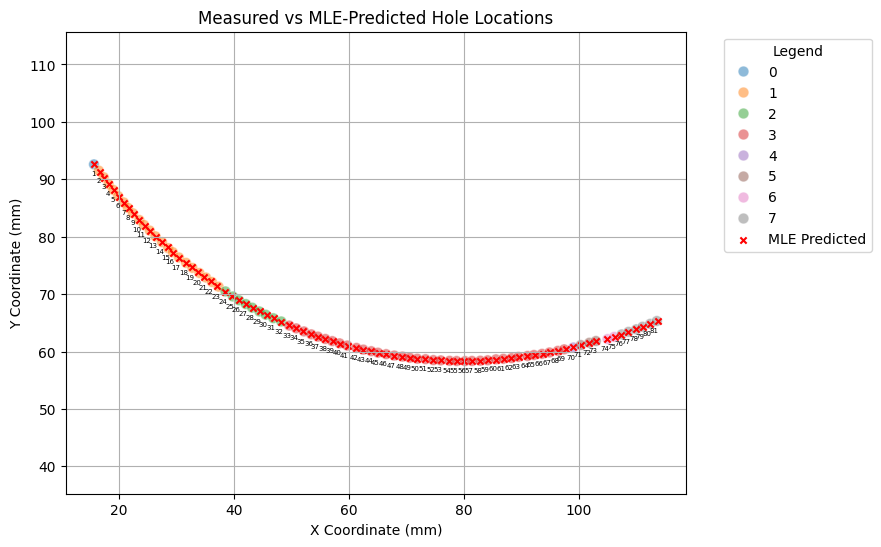

In [7]:
plt.figure(figsize=(8, 6))

# Plot measured hole locations
sns.scatterplot(data=df, x="Mean(X)", y="Mean(Y)", hue="Section ID", palette="tab10", s=60, alpha=0.5)

# Plot predicted hole locations from MLE
plt.scatter(predicted_x, predicted_y, color="red", marker="x", s=20, label="MLE Predicted")

# Annotate each hole number
for i, row in df.iterrows():
    plt.text(row["Mean(X)"] + 0.3, row["Mean(Y)"] - 2, str(int(row["Hole"])), fontsize=5, ha='right')

# Labels and formatting
plt.xlabel("X Coordinate (mm)")
plt.ylabel("Y Coordinate (mm)")
plt.title("Measured vs MLE-Predicted Hole Locations")
plt.legend(title="Legend", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axis("equal")
plt.grid(True)

# Show plot
plt.show()

# (f) Sample posterior with HMC